"There is a trade-off here: the longer the window length, the more these positive benefits
are realised; however if the window length becomes too large, the probability that a given window
contains more than one activity is increased, the delay before a classification output can be generated
is increased, and the number of training examples for the classifier will also be reduced.

Using a short window length enables near real-time
inference of the user’s current activity and ensures the detection can rapidly adapt to changes"

------------------------------------------
#**Notes:**


Tried :


- Resampled into even time space   
- Looked into HAR and how they used there filtering on accelometer - median , low pass 0.3 & 20hz  
- Calc row , yall & pitch   
- Rotate back to earth fixed frame 
- read in all data and resample everything to stop mess (cleaner mess notebook)
- some viz just to help see 
- introduce sliding window 



--------------------------------------

Handcrafted Features of Human Activity Recognition Dataset - they also performed a Fast Fourier Transform 

https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-84.pdf

https://github.com/PankajKarki/Human-Activity-recognition


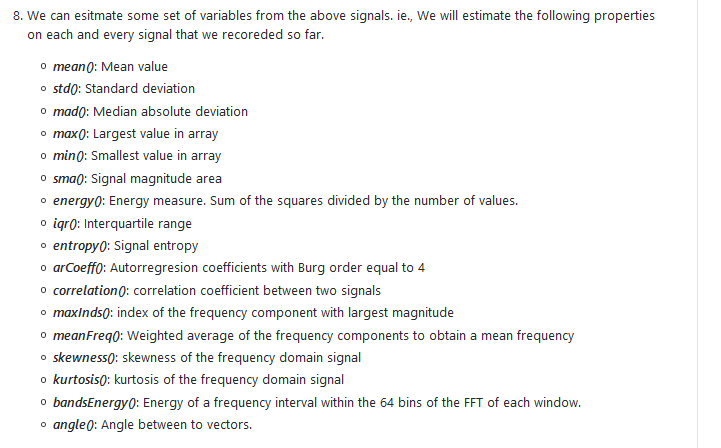

https://www.semanticscholar.org/paper/A-Public-Domain-Dataset-for-Human-Activity-using-Anguita-Ghio/83de43bc849ad3d9579ccf540e6fe566ef90a58e/figure/1

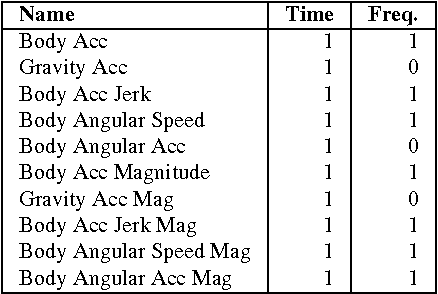

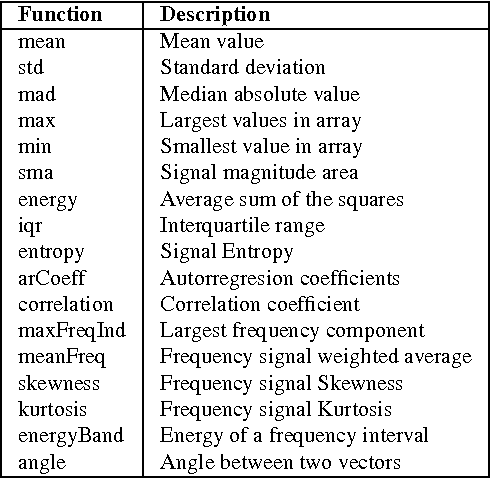

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import files
uploaded = files.upload()

# Imports

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import datetime
import statistics

# Read in data

In [ ]:
raw_acc_1 = pd.read_csv("08-04-2015 04.08.05.518 - Right Coat Pocket - TrialFPSV3502 - Raw Acceleration.csv" , 
                        skiprows=0 ,  header=1 )

In [ ]:
len(raw_acc_1)

In [ ]:
raw_acc_1.shape

In [ ]:
raw_acc_1.head()

## Drop Unnamed col & System Time 

In [ ]:
raw_acc_1 = raw_acc_1.drop(['Unnamed: 5' , 'System Time (ms)'], axis=1)

In [ ]:
raw_acc_1.isna().sum()

In [ ]:
raw_acc_1 = raw_acc_1.drop(1848)

In [ ]:
raw_acc_1.tail()

# Quick check of NA 

In [ ]:
raw_acc_1.isna().sum()

# Check Data types 

In [ ]:
raw_acc_1.dtypes

# Convert dtype of Event Time (ns) to datetime so can resample

In [ ]:
raw_acc_1['Time']  =  pd.to_datetime(raw_acc_1['Event Time (ns)'], unit='ns')

# this will give zero days instead of a date 
#raw_acc_1['Time']  =  pd.to_timedelta(raw_acc_1['Event Time (ns)'], unit='ns')

In [ ]:
raw_acc_1.head(10)

In [ ]:
raw_acc_1.dtypes

# Now set Time column as the index

In [ ]:
raw_acc_1.set_index('Time' ,  inplace=True)

In [ ]:
raw_acc_1

-------------------------------------------------------------------------------------

# Now resample time column to evenly space it out (phones not consistent)

In [ ]:
raw_acc_1_resampled  =  raw_acc_1.resample('10000000NS').bfill()

In [ ]:
raw_acc_1_resampled 

# Just incase dont want it time as index

In [ ]:
df = raw_acc_1_resampled.reset_index()

df.head()

------------------------

# Time difference

Hours : Mins : Seconds

so its 0.01 of a second, which is  $10^{-2}$ of a second 

In [ ]:
df.Time[1] - df.Time[0]

# Frequency 


1 occurance every 0.01 seconds    ->  F  = 1/0.01 = 100 hz 



In [ ]:
# imports 
import csv
import numpy as np
import math as m
import pandas as pd
from scipy import signal

import matplotlib.pyplot as plt


Going to copy HAR Preprocessing steps:

https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-84.pdf

- Median filter 
- 3rd order low-pass Butterworth Filter with a 20 Hz cutoff Freq (This rate is sufficient for capturing humanbody motion since99%of its energy is contained below 15Hz) 
- The acceleration signal, which has gravitational and body motion components, was separated using an-other Butterworth low-pass filter into body acceleration and gravity.  The gravitationalforce is assumed to have only low frequency components, therefore we found from the experiments that 0.3 Hz was an optimal corner frequency for a constant gravity signal

https://link.springer.com/article/10.1007/s12652-018-1110-y

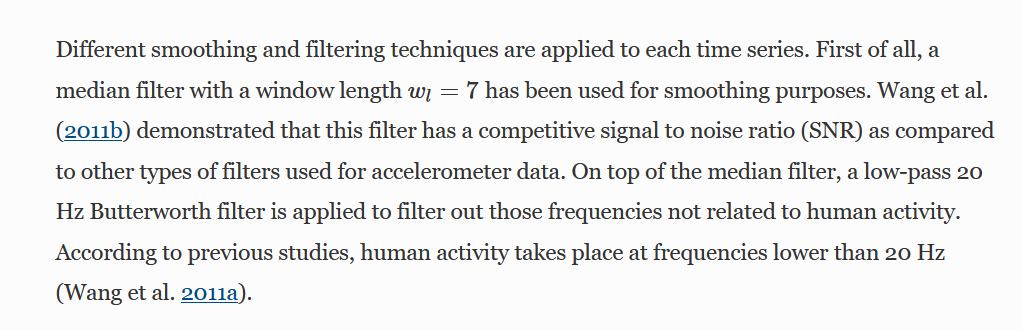

## Step 1: Median Filter 

In [ ]:
# Median Filter 

x1_median = signal.medfilt(raw_acc_1_resampled['X Axis'], kernel_size= 7)
y1_median = signal.medfilt(raw_acc_1_resampled['Y Axis'], kernel_size= 7)
z1_median = signal.medfilt(raw_acc_1_resampled['Z Axis'], kernel_size= 7)

In [ ]:
plt.plot(raw_acc_1_resampled.index , x1_median)
plt.show()

In [ ]:
plt.plot(raw_acc_1_resampled.index , y1_median)
plt.show()

In [ ]:
plt.plot(raw_acc_1_resampled.index , z1_median)
plt.show()

# Step 2: 3rd order low-pass Butterworth Filter with a 20 Hz cutoff Freq (This rate is sufficient for capturing human body motion since 99% of its energy is contained below 15Hz) 

In [ ]:
# Low Pass Filter body motion 

# sample frequecny
fs = 100
fc = 20

w = fc/(fs/2)
b,a = signal.butter(3, w, 'low')

x1_median_20hz = signal.filtfilt(b,a,x1_median)
y1_median_20hz = signal.filtfilt(b,a,y1_median)
z1_median_20hz = signal.filtfilt(b,a,z1_median)


In [ ]:
plt.plot(raw_acc_1_resampled.index , x1_median_20hz)
plt.show()

In [ ]:
plt.plot(raw_acc_1_resampled.index , y1_median_20hz)
plt.show()

In [ ]:
plt.plot(raw_acc_1_resampled.index , z1_median_20hz)
plt.show()

## Step 3: The acceleration signal, which has gravitational and body motion components, was separated using another Butterworth low-pass filter into body acceleration and gravity.  The gravitational force is assumed to have only low frequency components, therefore we found from the experiments that 0.3 Hz was an optimal corner frequency for a constant gravity signal

Efficient Human Activity Recognition Using a Single Wearable Sensor
https://ieeexplore.ieee.org/document/9097303



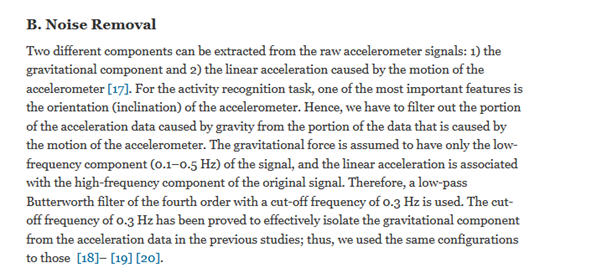

In [ ]:
# Low Pass Filter 

# sample frequecny
fs = 100

#Cut off frequency
fc = 0.3


w = fc/(fs/2)
b,a = signal.butter(4, w, 'low')

x1_median_20hz_gravity = signal.filtfilt(b,a,x1_median_20hz)
y1_median_20hz_gravity = signal.filtfilt(b,a,y1_median_20hz)
z1_median_20hz_gravity = signal.filtfilt(b,a,z1_median_20hz)


# x1_median_20hz_gravity = signal.filtfilt(b,a,raw_acc_1_resampled['X Axis'])
# y1_median_20hz_gravity = signal.filtfilt(b,a,raw_acc_1_resampled['Y Axis'])
# z1_median_20hz_gravity = signal.filtfilt(b,a,raw_acc_1_resampled['Z Axis'])


In [ ]:
x_squared = x1_median_20hz_gravity**2
y_squared = y1_median_20hz_gravity**2
z_squared = z1_median_20hz_gravity**2

total_squared = x_squared + y_squared  + z_squared


# want the mean of this to keep gravity constant throughout the trial 
value_total_acc = np.sqrt(np.mean(total_squared))

# calculating std 
std_total =  np.std(np.sqrt(total_squared))

diff =  value_total_acc - 9.81 

print(f"Mean force: {value_total_acc} ,  STD: {std_total} ,  Diff {diff}")

In [ ]:
plt.plot(raw_acc_1_resampled.index , x1_median_20hz_gravity)
plt.show()

In [ ]:
plt.plot(raw_acc_1_resampled.index , y1_median_20hz_gravity)
plt.show()

In [ ]:
plt.plot(raw_acc_1_resampled.index , z1_median_20hz_gravity)
plt.show()

From their paper https://arxiv.org/ftp/arxiv/papers/1708/1708.08989.pdf

- their code was available on github and they substract gravity component from total to get movement 

https://github.com/guillaume-chevalier/HAR-stacked-residual-bidir-LSTMs/blob/master/data/signal_filtering.py

In [ ]:
x1_median_20hz_movement = x1_median_20hz - x1_median_20hz_gravity
y1_median_20hz_movement = y1_median_20hz - y1_median_20hz_gravity
z1_median_20hz_movement = z1_median_20hz - z1_median_20hz_gravity

In [ ]:
plt.plot(raw_acc_1_resampled.index , x1_median_20hz_movement)
plt.show()

In [ ]:
plt.plot(raw_acc_1_resampled.index , y1_median_20hz_movement)
plt.show()

In [ ]:
plt.plot(raw_acc_1_resampled.index , z1_median_20hz_movement)
plt.show()

------------------------------------------------------------------

# Need to rotate from body fixed frame to earth fixed frame 

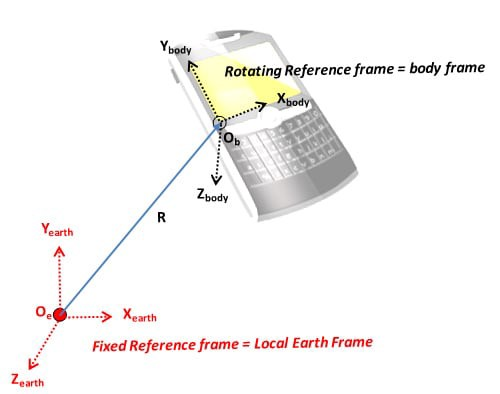-

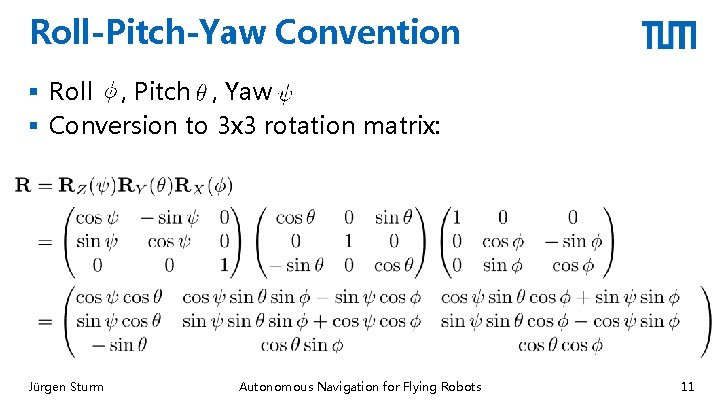

https://www.projectrhea.org/rhea/index.php/Accelerometer

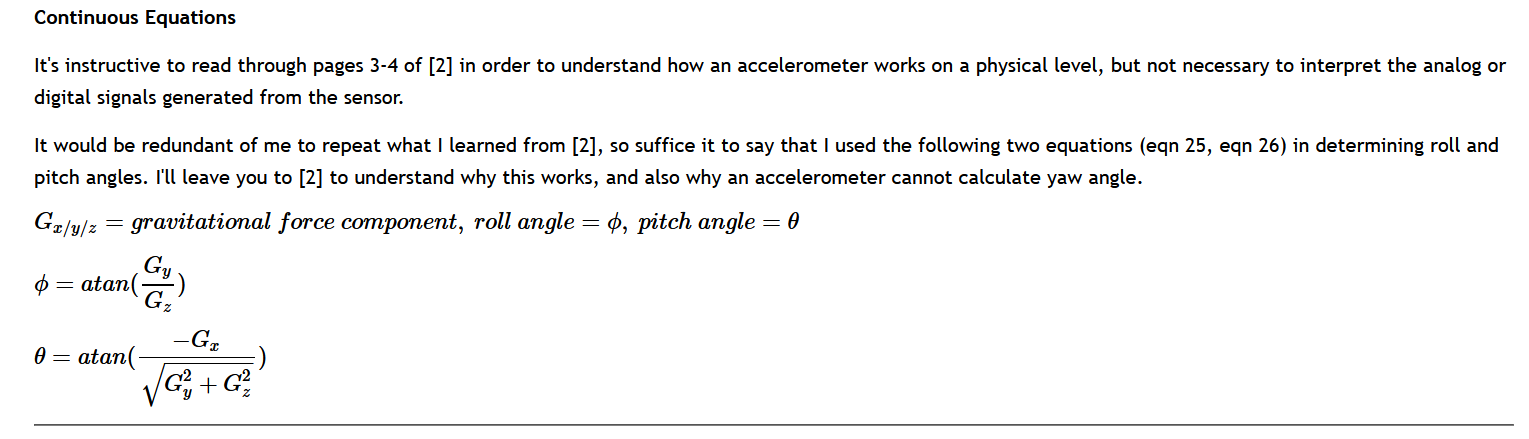

https://cdn.instructables.com/ORIG/F9L/9J61/JZX16QZA/F9L9J61JZX16QZA.pdf

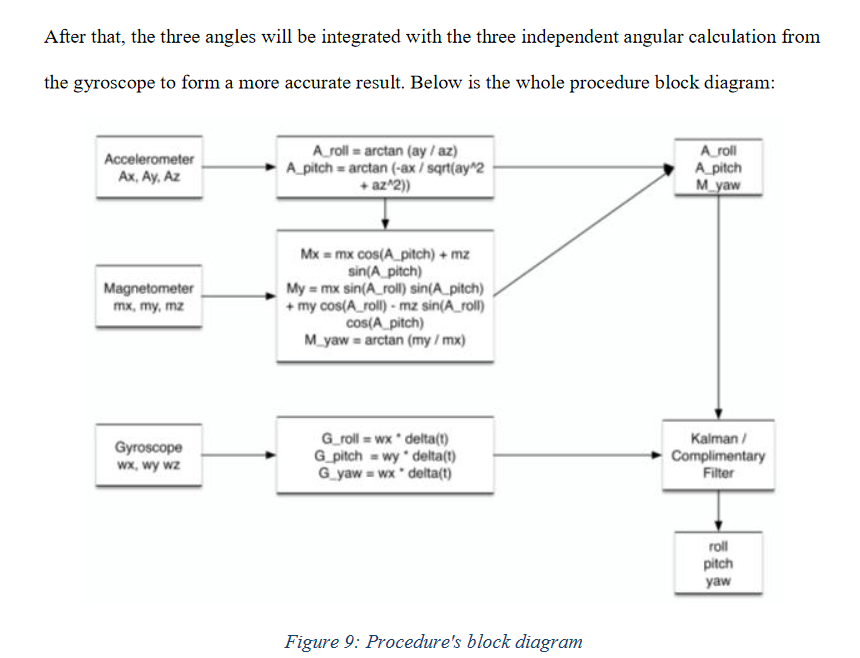



In [ ]:
#define angles for transfromation matrix

def Phi(y,z, degrees = False):

  "Calculates Roll Angle. If Degrees is set to true, the angles measurement is in degress and will be converted to radians."

  gy = y

  gz = z

  roll = gy / gz 

  if degrees == True:

    # convert degrees to radian 
    roll = math.radians(roll)

  return (m.atan(roll))


def Theta(x, y , z , degrees = False):

  "Calculate Pitch Angle"

  neg_gx = -x

  gy_square = y**2 
  gz_square = z**2

  pitch = neg_gx / ( np.sqrt(gy_square + gz_square))

  if degrees == True:

    # convert degrees to radian 
    pitch = m.radians(pitch)

  return (m.atan(pitch))
    

In [ ]:
pitch_1 = Theta( x1_median_20hz_gravity[0] , y1_median_20hz_gravity[0] ,  z1_median_20hz_gravity[0] )

In [ ]:
roll_1 = Phi( y1_median_20hz_gravity[0] ,  z1_median_20hz_gravity[0]  )

--------------------------------------------------------

# Read in Magnometer 

In [ ]:
raw_mag_1 = pd.read_csv("08-04-2015 04.08.05.545 - Right Coat Pocket - TrialFPSV3502 - Raw Magnetometer.csv" , 
                        skiprows=0 ,  header=1 )

In [ ]:
raw_mag_1

In [ ]:
raw_mag_1['X Axis'].describe()

In [ ]:
raw_mag_1['Y Axis'].describe()

In [ ]:
raw_mag_1['Z Axis'].describe()

In [ ]:
raw_mag_1.shape

In [ ]:
raw_mag_1 = raw_mag_1.drop(1848)

In [ ]:
# now resample time 

raw_mag_1['Time']  =  pd.to_datetime(raw_mag_1['Event Time (ns)'], unit='ns')

raw_mag_1.set_index('Time' ,  inplace=True)

raw_mag_1_resampled  =  raw_mag_1.resample('10000000NS').bfill()

In [ ]:
raw_mag_1_resampled.shape

In [ ]:
raw_mag_1.isna().sum()

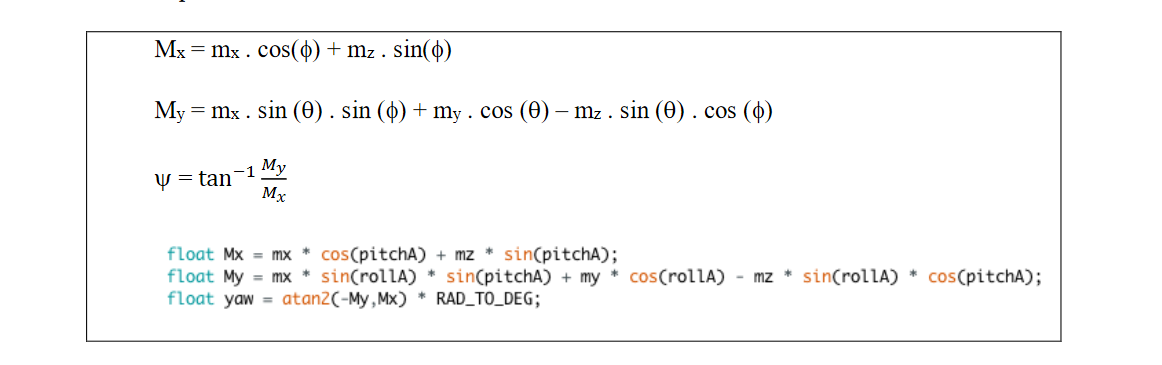



where swap roll & pitch from above , as in this paper they defined: 

- roll = theta 
- pitch = phi 
- yaw = psi 

**Where as have used so far:** 

- pitch = theta 
- roll = phi
- yaw = psi

In [ ]:
# Mx 
def psi(x_mag , y_mag , z_mag , roll , pitch ):

  x = x_mag 
  y = y_mag 
  z = z_mag

  roll = roll 
  pitch = pitch 

  Mx = x * m.cos(roll_1) + z * m.sin(roll_1)  

  My = x * m.sin(pitch_1) * m.sin(roll_1)  \
     + y * m.cos(pitch_1)                  \
     - z * m.sin(pitch_1) * m.cos(roll_1)


  yaw = m.atan(My / Mx)

  return yaw


In [ ]:
yaw_1 = psi(raw_mag_1['X Axis'][0] , raw_mag_1['Y Axis'][0] , raw_mag_1['Z Axis'][0] , roll = roll_1 , pitch= pitch_1)

In [ ]:
print(yaw_1)

In [ ]:
print(f'Roll (phi): {roll_1}')
print(f'Pitch (theta): {pitch_1}')
print(f'Yaw (psi): {yaw_1}')

----------------------------

# Preprocess stuff for kalman if needed

https://towardsdatascience.com/sensor-fusion-part-2-kalman-filter-code-78b82c63dcd


https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html


https://pykalman.github.io/

### Read in Gyro 

In [ ]:
# need to read in gyro measurements 
raw_gyro_1 = pd.read_csv("08-04-2015 04.08.05.572 - Right Coat Pocket - TrialFPSV3502 - Raw Gyro.csv" , 
                        skiprows=0 ,  header=1 )
raw_gyro_1

In [ ]:
# drop last row 

raw_gyro_1 = raw_gyro_1.drop(1848)

# now resample time 

raw_gyro_1['Time']  =  pd.to_datetime(raw_gyro_1['Event Time (ns)'], unit='ns')

raw_gyro_1.set_index('Time' ,  inplace=True)

raw_gyro_1_resampled  =  raw_gyro_1.resample('10000000NS').bfill()

In [ ]:
###########

raw_gyro_1_resampled

In [ ]:
# wx , wy , wz  * delta(t)

raw_gyro_1_resampled['G_Roll'] = raw_gyro_1_resampled['Roll'] * (0.01)
raw_gyro_1_resampled['G_Pitch'] = raw_gyro_1_resampled['Pitch'] * (0.01)
raw_gyro_1_resampled['G_Yaw'] = raw_gyro_1_resampled['Yaw'] * (0.01)

In [ ]:
raw_gyro_1_resampled

-------------------------------------------------------------------

In [ ]:
print(f'Roll (phi): {roll_1}')
print(f'Pitch (theta): {pitch_1}')
print(f'Yaw (psi): {yaw_1}')

--------------------

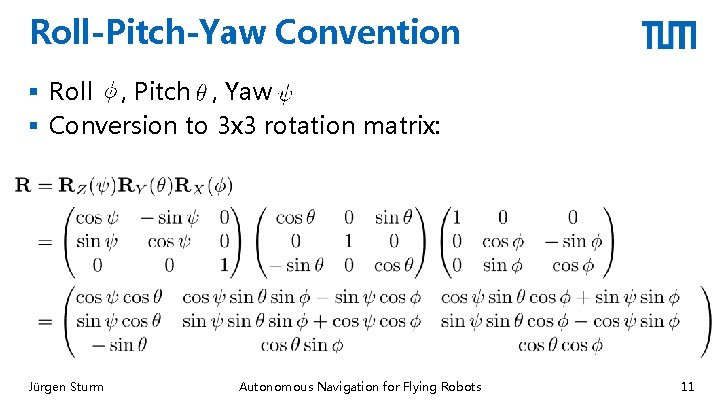

In [ ]:

#define the x column of the rotation matrix

def Rx(phi):
    return np.matrix([[1,                  0,                       0], 
                      [0,               m.cos(phi),    -m.sin(phi)],
                      [0,               m.sin(phi),    m.cos(phi)]])

def Ry(theta):
    return np.matrix([[m.cos(theta),      0            , m.sin(theta)],
                      [0                 ,1                        ,0],
                      [-m.sin(theta),     0,             m.cos(theta)]])

def Rz(psi):
    return np.matrix([[m.cos(psi),     -m.sin(psi) ,            0],
                      [m.sin(psi)   ,   m.cos(psi) ,            0],
                      [0 ,                    0,                1]])

Rotational stuff 

In [ ]:
#Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
R1 = Rz(yaw_1) * Ry(pitch_1) * Rx(roll_1)


print(R1)

In [ ]:
#Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
R1_1 = Rz(yaw_1+1) * Ry(pitch_1) * Rx(roll_1)


print(R1_1)

----------------------------------------

In [ ]:
array_test = [ [x1_median_20hz_gravity[0]] , [y1_median_20hz_gravity[0]] ,  [z1_median_20hz_gravity[0]] ]

In [ ]:
print( array_test[0] , array_test[1] , array_test[2] )

In [ ]:
array_test

In [ ]:
rot_x , rot_y , rot_z = R1 * array_test

In [ ]:
rot_x

In [ ]:
rot_x = rot_x.astype(float)

In [ ]:
rot_y

In [ ]:
rot_z

-------------------------------------------

So phone isnt constant througout test , as this should be approx constant 0

In [ ]:
arr_x , arr_y , arr_z = R1 * [ x1_median_20hz_gravity , y1_median_20hz_gravity ,  z1_median_20hz_gravity]

In [ ]:
ar_x = np.array(arr_x)

ar_x_s = np.squeeze(ar_x)

plt.plot(ar_x_s)
plt.show()

----------------------------------------------

In [ ]:
raw_gyro_1_resampled.shape

In [ ]:
raw_acc_1_resampled.shape

In [ ]:
raw_mag_1_resampled.shape

# now check entire thing 

# Since we extracted the gravity part alone (not fully it seems?) we should have approx constant 0 on x & y  and roughly 9.8 on z 

In [ ]:
# Now repeat for each stage 

x_rotted = [] 
y_rotted = [] 
z_rotted = [] 

x_move_rotted = [] 
y_move_rotted = [] 
z_move_rotted = [] 


for i in range(len(x1_median_20hz_gravity)):

  # Uses Acc
  pitch_1 = Theta( x1_median_20hz_gravity[i] , y1_median_20hz_gravity[i] ,  z1_median_20hz_gravity[i] )
  roll_1 = Phi( y1_median_20hz_gravity[i] ,  z1_median_20hz_gravity[i]  )

  x_mag = raw_mag_1_resampled['X Axis'][i]
  y_mag = raw_mag_1_resampled['Y Axis'][i]
  z_mag = raw_mag_1_resampled['Z Axis'][i]

  # uses Mag 
  yaw_1 = psi( x_mag  , y_mag , z_mag  , roll = roll_1 , pitch = pitch_1)


  #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
  R1 = Rz(yaw_1) * Ry(pitch_1) * Rx(roll_1)

  # put into array for multiplication 
  array_test = [ [x1_median_20hz_gravity[i]] , [y1_median_20hz_gravity[i]] ,  [z1_median_20hz_gravity[i]] ]

  # put movement acc into array for multiplication 
  array_test_move = [ [x1_median_20hz_movement[i]] , [y1_median_20hz_movement[i]] ,  [z1_median_20hz_movement[i]] ]

  # rotated values 
  rot_x , rot_y , rot_z = R1 * array_test


  # rotated values 
  rot_x_move , rot_y_move , rot_z_move = R1 * array_test_move

  # append 
  x_rotted.append(rot_x)
  y_rotted.append(rot_y)
  z_rotted.append(rot_z)


  # append 
  x_move_rotted.append(rot_x_move)
  y_move_rotted.append(rot_y_move)
  z_move_rotted.append(rot_z_move)


In [ ]:
arr_x_rotted = np.array(x_rotted)
arr_y_rotted = np.array(y_rotted)
arr_z_rotted = np.array(z_rotted)


arr_x_move_rotted = np.array(x_move_rotted)
arr_y_move_rotted = np.array(y_move_rotted)
arr_z_move_rotted = np.array(z_move_rotted)

In [ ]:
arr_x_rotted_squeez = np.squeeze(arr_x_rotted)
arr_y_rotted_squeez = np.squeeze(arr_y_rotted)
arr_z_rotted_squeez = np.squeeze(arr_z_rotted)

arr_x_move_rotted_squeez = np.squeeze(arr_x_move_rotted)
arr_y_move_rotted_squeez = np.squeeze(arr_y_move_rotted)
arr_z_move_rotted_squeez = np.squeeze(arr_z_move_rotted)

In [ ]:
new_df = pd.DataFrame()

In [ ]:
new_df['X_Rot'] = arr_x_rotted_squeez 
new_df['Y_Rot'] = arr_y_rotted_squeez 
new_df['Z_Rot'] = arr_z_rotted_squeez 


new_df['X_Rot_move'] = arr_x_move_rotted_squeez 
new_df['Y_Rot_move'] = arr_y_move_rotted_squeez 
new_df['Z_Rot_move'] = arr_z_move_rotted_squeez 

In [ ]:
new_df['X_Rot'].plot()

In [ ]:
new_df['X_Rot_move'].plot()

In [ ]:
new_df['Y_Rot'].plot()

In [ ]:
new_df['Z_Rot'].plot()

In [ ]:
new_df['Z_Rot'].mean()

In [ ]:
new_df.shape

-------------------------------------------------

how does a 1 unit change in Yaw yield:

In [ ]:

delta_list = np.arange(0,1,0.01)

In [ ]:


for delta in np.arange(0,1,0.01):

  # Uses Acc
  pitch_1 = Theta( x1_median_20hz_gravity[0] , y1_median_20hz_gravity[0] ,  z1_median_20hz_gravity[0] )
  roll_1 = Phi( y1_median_20hz_gravity[0] ,  z1_median_20hz_gravity[0]  )

  x_mag = raw_mag_1_resampled['X Axis'][0]
  y_mag = raw_mag_1_resampled['Y Axis'][0]
  z_mag = raw_mag_1_resampled['Z Axis'][0]

  # uses Mag 
  yaw_1 = psi( x_mag  , y_mag , z_mag  , roll = roll_1 , pitch = pitch_1)


  #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
  R1 = Rz(yaw_1) * Ry(pitch_1) * Rx(roll_1)

  #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
  R1_1 = Rz(yaw_1) * Ry(pitch_1+delta) * Rx(roll_1 )


  # put into array for multiplication 
  array_test = [ [x1_median_20hz_gravity[0]] , [y1_median_20hz_gravity[0]] ,  [z1_median_20hz_gravity[0]] ]

  # put movement acc into array for multiplication 
  array_test_move = [ [x1_median_20hz_movement[0]] , [y1_median_20hz_movement[0]] ,  [z1_median_20hz_movement[0]] ]

  # rotated values 
  rot_x , rot_y , rot_z = R1 * array_test

  # rotated values 
  rot_x_1 , rot_y_1 , rot_z_1 = R1 * array_test


  print("\n\nNormal: ", rot_z , "angle" , yaw_1) 
  print(f"Normal + {delta} : ", rot_z_1, "angle" , yaw_1+delta) 

  print("Abs Change : ", "{:.20f}".format(float(rot_z_1 - rot_z))  )

  print("\n\n------------------------------------------")



------------------------------

Far too computation

In [ ]:
# # Now repeat for each stage 

# x_rotted = [] 
# y_rotted = [] 
# z_rotted = [] 


# angle_roll = []
# angle_pitch = []
# angle_yaw = []



# for i in range(len(x1_median_20hz_gravity)):


#   # Uses Acc
#   pitch_1 = Theta( x1_median_20hz_gravity[i] , y1_median_20hz_gravity[i] ,  z1_median_20hz_gravity[i] )
#   roll_1 = Phi( y1_median_20hz_gravity[i] ,  z1_median_20hz_gravity[i]  )

#   x_mag = raw_mag_1_resampled['X Axis'][i]
#   y_mag = raw_mag_1_resampled['Y Axis'][i]
#   z_mag = raw_mag_1_resampled['Z Axis'][i]

#   # uses Mag 
#   yaw_1 = psi( x_mag  , y_mag , z_mag  , roll = roll_1 , pitch = pitch_1)


#   #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
#   R1 = Rz(yaw_1) * Ry(pitch_1) * Rx(roll_1)


#   # put into array for multiplication 
#   array_test = [ [x1_median_20hz_gravity[i]] , [y1_median_20hz_gravity[i]] ,  [z1_median_20hz_gravity[i]] ]

#   # put movement acc into array for multiplication 
#   array_test_move = [ [x1_median_20hz_movement[i]] , [y1_median_20hz_movement[i]] ,  [z1_median_20hz_movement[i]] ]

#   # rotated values 
#   rot_x , rot_y , rot_z = R1 * array_test


#   if rot_z >= 9.8 and rot_z <= 9.82 and rot_x <= 0.001 and rot_y <= 0.001:
#     # append 

#     #print(f"Hit on original")

#     x_rotted.append(rot_x)
#     y_rotted.append(rot_y)
#     z_rotted.append(rot_z)

#     angle_roll.append(roll_1)
#     angle_pitch.append(pitch_1)
#     angle_yaw.append(yaw_1)


#   else: 

#     #print("Enter Else")

#     ############################# Change Yaw ####################

#     for delta in range(-5,5):

#       yaw_1_delta = yaw_1 + delta 
#       roll_1_delta = roll_1 
#       pitch_1_delta = pitch_1 


#       #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
#       R1 = Rz(yaw_1_delta) * Ry( pitch_1_delta) * Rx(roll_1_delta)

#       # rotated values 
#       rot_x , rot_y , rot_z = R1 * array_test


#       if rot_z >= 9.8 and rot_z <= 9.82 and rot_x <= 0.001 and rot_y <= 0.001:
#       # append 
#         x_rotted.append(rot_x)
#         y_rotted.append(rot_y)
#         z_rotted.append(rot_z)

#         angle_roll.append(roll_1_delta)
#         angle_pitch.append( pitch_1_delta)
#         angle_yaw.append(yaw_1_delta)

#         print(f"Hit on: {delta}")



#       ############################# Change Roll ####################

#       for delta in range(-5,5):

#         yaw_1_delta = yaw_1
#         roll_1_delta = roll_1  + delta 
#         pitch_1_delta = pitch_1 


#         #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
#         R1 = Rz(yaw_1_delta) * Ry( pitch_1_delta) * Rx(roll_1_delta)

#         # rotated values 
#         rot_x , rot_y , rot_z = R1 * array_test


#         if rot_z >= 9.8 and rot_z <= 9.82 and rot_x <= 0.001 and rot_y <= 0.001:
#         # append 
#           x_rotted.append(rot_x)
#           y_rotted.append(rot_y)
#           z_rotted.append(rot_z)

#           angle_roll.append(roll_1_delta)
#           angle_pitch.append( pitch_1_delta)
#           angle_yaw.append(yaw_1_delta)

#           print(f"Hit on: {delta}")


#         ############################# Change Pitch ####################

#         for delta in range(-5,5):

#           yaw_1_delta = yaw_1
#           roll_1_delta = roll_1   
#           pitch_1_delta = pitch_1 + delta


#           #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
#           R1 = Rz(yaw_1_delta) * Ry( pitch_1_delta) * Rx(roll_1_delta)

#           # rotated values 
#           rot_x , rot_y , rot_z = R1 * array_test


#           if rot_z >= 9.8 and rot_z <= 9.82 and rot_x <= 0.001 and rot_y <= 0.001:
#           # append 
#             x_rotted.append(rot_x)
#             y_rotted.append(rot_y)
#             z_rotted.append(rot_z)

#             angle_roll.append(roll_1_delta)
#             angle_pitch.append( pitch_1_delta)
#             angle_yaw.append(yaw_1_delta)

#             print(f"Hit on: {delta}")


In [ ]:
len(x1_median_20hz_gravity) 



In [ ]:
# len(angle_roll)

In [ ]:
# arr_x_rotted = np.array(x_rotted)
# arr_y_rotted = np.array(y_rotted)
# arr_z_rotted = np.array(z_rotted)

In [ ]:
# arr_x_rotted_squeez = np.squeeze(arr_x_rotted)
# arr_y_rotted_squeez = np.squeeze(arr_y_rotted)
# arr_z_rotted_squeez = np.squeeze(arr_z_rotted)

In [ ]:
# new_df = pd.DataFrame()

# new_df['X_Rot'] = arr_x_rotted_squeez 
# new_df['Y_Rot'] = arr_y_rotted_squeez 
# new_df['Z_Rot'] = arr_z_rotted_squeez 


In [ ]:
# plt.plot(new_df.index, new_df['Z_Rot'])
# plt.ylim(0,10)
# plt.show()



In [ ]:
# new_df['X_Rot'].plot()


In [ ]:
# new_df['Y_Rot'].plot()

-----------------------

In [ ]:
# import modules
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz
from numpy import sin,cos,pi
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn')

In [ ]:
dt = 0.01

# Double integrate accelerations to find positions
x =cumtrapz(cumtrapz(new_df['X_Rot_move'],dx=dt),dx=dt)
y =cumtrapz(cumtrapz(new_df['Y_Rot_move'],dx=dt),dx=dt)
z =cumtrapz(cumtrapz(new_df['Z_Rot_move'],dx=dt),dx=dt)# Plot 3D Trajectory


fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5,label='phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')


# Set rotation angle to 30 degrees
ax.view_init(azim=180)

plt.show()




In [ ]:
# Try to remove noise via Fourier analysis
    # Discrete Fourier Transform sample frequencies
freq = np.fft.rfftfreq(new_df['X_Rot_move'].size,d=dt)

# Compute the Fast Fourier Transform (FFT) of acceleration signals
fft_x = np.fft.rfft(new_df['X_Rot_move']) 
fft_y = np.fft.rfft(new_df['Y_Rot_move']) 
fft_z = np.fft.rfft(new_df['Z_Rot_move'])

# Plot Frequency spectrum
fig4,[ax1,ax2,ax3] = plt.subplots(3,1,sharex=True,sharey=True)
fig4.suptitle('Noise Spectrum',fontsize=20)
ax1.plot(freq,abs(fft_x),c='r',label='x noise')
ax1.legend()
ax2.plot(freq,abs(fft_y),c='b',label='y noise')
ax2.legend()
ax3.plot(freq,abs(fft_z),c='g',label='z noise')
ax3.legend()
ax3.set_xlabel('Freqeuncy (Hz)')
plt.show()

In [ ]:
# Attenuate noise in X,Y below 10Hz by 10 dB
# Attenuate noise <10Hz and >5Hz in Z axis by 10 dB
atten_x_fft = np.where(freq < 10,fft_x * 0.1, fft_x) 
atten_y_fft = np.where(freq < 10,fft_y * 0.1, fft_y) 
atten_z_fft = np.where((freq > 5) & (freq < 10),fft_z * 0.1, fft_z) 


# Compute inverse of discrete Fourier Transform 
new_df['x_ifft'] = np.fft.irfft(atten_x_fft,n=df.shape[0])
new_df['y_ifft'] = np.fft.irfft(atten_y_fft,n=df.shape[0])
new_df['z_ifft'] = np.fft.irfft(atten_z_fft,n=df.shape[0])


# Plot new acceleration signals
cols_raw = ['X_Rot_move','Y_Rot_move','Z_Rot_move']
cols_new = ['x_ifft','y_ifft','z_ifft']

rawplot = new_df.plot( y=cols_raw, subplots=True, sharex=True, style='k', title=cols_raw, alpha=0.5 , layout = (1,3))

new_df.plot(y=cols_new,subplots=True,layout=(1,3),ax=rawplot,sharex=True,style='g')
plt.show()

In [ ]:
dt = 0.01



# Double integrate accelerations to calculate coordinate positions
x = cumtrapz(cumtrapz(new_df['x_ifft'],dx=dt),dx=dt)
y = cumtrapz(cumtrapz(new_df['y_ifft'],dx=dt),dx=dt)
z = cumtrapz(cumtrapz(new_df['z_ifft'],dx=dt),dx=dt)



fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)


# Plot attenuated 3D Trajectory
ax = plt.axes(projection='3d')

ax.plot3D(x,y,z,'k',lw=5,label='Attenuated phone trajectory')

ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')

ax.legend(fontsize='x-large')
plt.show()

-------------------------------------

In [ ]:
new_df.tail()

----------------------------------------

.

In [ ]:
np.sign(0)

In [ ]:
change_of_sign = []

a = [ 0 , 2 , -2 ,-3 , -4 , 5 ,6 ]


# iterate through the values of the segment
sign_change = 0

for i in a:

  # determine sign manually just so that there is  no confusions around 0 if it occurs

  # This is the starting sign value of the segment, if positive start sign = 1 
  if a[0] >= 0:
    start_sign = 1
  
  # else its negative = 0 
  else:
    start_sign = 0

 # This is the current sign value in the segment, if positive start sign = 1 
  if i >= 0:
    current_sign = 1

  else:
    current_sign = 0




  # if start sign and current sign differ, must be a sign change , so set sign change = 1 to represent a change in sign 
  if start_sign != current_sign:

    # means there was a change
    sign_change = 1


change_of_sign.append(sign_change )



In [ ]:
print(change_of_sign)

.

.

.

# Look into markers

In [ ]:
marker_1 = pd.read_csv("08-04-2015 13.06.09.853 - TrialFPSV3502 - Markers.csv" , 
                        skiprows=0 ,  header=1 )

In [ ]:
marker_1.head()

In [ ]:
marker_1.isna().sum()

In [ ]:
marker_1.tail()

In [ ]:
print(len(marker_1))

In [ ]:
marker_1.shape

In [ ]:
marker_1 = marker_1.drop(len(marker_1)-1)

In [ ]:
marker_1.dtypes

In [ ]:
marker_1 = marker_1.astype({'Local Time (ms)': float})

In [ ]:
marker_1.dtypes

# Reorder in ascending in local time 

In [ ]:
marker_1.sort_values(by=['Local Time (ms)'], inplace=True, ascending=True)

In [ ]:
marker_1

# Use Relative time instead , didnt seem to work? Or is timestamp off 

In [ ]:
marker_1.sort_values(by=['Relative Time (ms)'], inplace=True, ascending=True)

In [ ]:
marker_1

Make a datetime type  

In [ ]:
marker_1['Test']  =  pd.to_datetime(marker_1['Relative Time (ms)'], unit='ms')

-----------------------------------------------

Not sure if this is used, think its roughwork 

In [ ]:
marker_1

In [ ]:
marker_1['Test_2'] = marker_1['Local Time (ms)'] + marker_1['Local-Remote time']

In [ ]:
marker_1

In [ ]:
marker_1['Test_3']  =  pd.to_datetime(marker_1['Test'], unit='ms')

In [ ]:
marker_1

In [ ]:
marker_1['Test_3'] == marker_1['Test']

------------------------------------------------------------------

# Rename elements 

In [ ]:
# rename to walk 1 
marker_1.at[4, 'Label'] = 'Walk 1'

#rename to turn 1 
marker_1.at[5, 'Label'] = 'Turn 1'

# rename to walk 2
marker_1.at[6, 'Label'] = 'Walk 2'

#rename to turn 2
marker_1.at[7, 'Label'] = 'Turn 2'



In [ ]:
marker_1

-------------------------------------------------------

In [ ]:
raw_acc_1_1 = pd.read_csv("08-04-2015 04.08.05.518 - Right Coat Pocket - TrialFPSV3502 - Raw Acceleration.csv" , 
                        skiprows=0 ,  header=1 )

In [ ]:
raw_acc_1_1 = raw_acc_1_1.drop(1848)

In [ ]:
# convert Relative time to ns 

# ms  10^-3    ns 10^-9      ms -> ns  multiply by 10^6 

In [ ]:
marker_1['RTNS'] = marker_1['Relative Time (ms)'] * (10**6)

In [ ]:
marker_1

In [ ]:
raw_acc_1_1['Event Time (ns)'][0]

In [ ]:
# now add onto it the event time from raw acceleration 

marker_1['New'] = marker_1['RTNS'] + raw_acc_1_1['Event Time (ns)'][0]

In [ ]:
marker_1

In [ ]:
marker_1['Last Time']  =  pd.to_datetime(marker_1['New'], unit='ns')

In [ ]:
marker_1

----------------------------------------------------------

In [ ]:
of_interest = marker_1[['Last Time', 'Label']]

In [ ]:
of_interest

In [ ]:
# need to drop the first row as its duplicate in the terms of index

of_interest = of_interest.drop(0)

In [ ]:
of_interest.set_index('Last Time' ,  inplace=True)

In [ ]:
of_interest

In [ ]:
labels = of_interest.Label.values

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()


In [ ]:
of_interest['Cat_Label'] = le.fit_transform(of_interest['Label'])

In [ ]:
of_interest

In [ ]:
#convert labels to vals  
#of_interest["Cat_Label"] =  of_interest["Label"].astype('category')

In [ ]:
#of_interest["Cat_Label"] = of_interest["Cat_Label"].cat.codes

In [ ]:
#new_interest = of_interest.drop(['Cat'] , axis = 1)

In [ ]:
of_interest = of_interest.resample('10000000NS').bfill()

-------------------------------------

In [ ]:
last_df = pd.concat([raw_acc_1_resampled, of_interest ] , axis = 1)

In [ ]:
last_df

In [ ]:
last_df.tail(20)

In [ ]:
last_df.isna().sum()

In [ ]:
last_df.shape

In [ ]:
# filter out nan at the end 

last_df = last_df.dropna()

In [ ]:
last_df.tail(20)

--------------------------------------------

In [ ]:
last_df.shape

In [ ]:
last_df.head(10)

In [ ]:
last_df['Label'].unique()

In [ ]:
last_df.shape

---------------------------------------

In [ ]:
# # since drop out stop sync service need to remove some of the data fro median filter

# len(x1_median_20hz[:-116])

# len(y1_median_20hz[:-116])

# len(z1_median_20hz[:-116])

In [ ]:
last_df['Accel X'] = x1_median_20hz_movement
last_df['Accel Y'] = y1_median_20hz_movement
last_df['Accel Z'] = z1_median_20hz_movement

In [ ]:
last_df.tail()

-------------------------

------------------------------

FFT Testing 

https://realpython.com/python-scipy-fft/

<br>

<br>


In [ ]:
from scipy.fft import fft, fftfreq , rfft , rfftfreq

In [ ]:
# Number of samples in signal
N = last_df.shape[0]

# Sampling rate is 100Hz 
SAMPLE_RATE = 100

# Detrending data (advice from stack overflow to overcome 0 Hz main frequency)
all = (last_df['Accel X'].values - last_df['Accel X'].values.mean())

# Applying FFT
yf = rfft(all)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


# Plots
plt.xlabel("Frequency Domain")
plt.ylabel("Power")
plt.title("All Accel X")

#plt.xlim(-1,20)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
# Number of samples in signal
N = last_df.shape[0]

SAMPLE_RATE = 100

input_all = (last_df['Accel Y'].values) - (last_df['Accel Y'].values.mean())

yf = rfft(input_all)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.title("All Accel Y")


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

#plt.xlim(-1,20)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
# Number of samples in signal
N = last_df.shape[0]

SAMPLE_RATE = 100

input_all = (last_df['Accel Z'].values) - (last_df['Accel Z'].values.mean())

yf = rfft(input_all)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("All Accel Z")

#plt.xlim(0,3)

plt.plot(xf, np.abs(yf))
plt.show()

------------------------------------------------

# Go

**X**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Go'].shape[0]

# Sampling rate is 100Hz 
SAMPLE_RATE = 100


# Detrending data (advice from stack overflow to overcome 0 Hz main frequency)
go_x = (last_df[last_df['Label'] == 'Go']['X Axis'].values) - (last_df[last_df['Label'] == 'Go']['X Axis'].values.mean())

yf = rfft(go_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

# Plots
plt.xlabel("Frequency Domain")
plt.ylabel("Power")
plt.title("Accel X for Go Stage")

#plt.xlim(-5, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Go'].shape[0]

SAMPLE_RATE = 100

go_y = (last_df[last_df['Label'] == 'Go']['Y Axis'].values) - (last_df[last_df['Label'] == 'Go']['Y Axis'].values.mean())

yf = rfft(go_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.title("Accel Y for Go Stage")

plt.xlabel("Frequency Domain")
plt.ylabel("Power")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Go'].shape[0]

SAMPLE_RATE = 100


# found stack overflow saying remove mean 
input = (last_df[last_df['Label'] == 'Go']['Z Axis'].values) - (last_df[last_df['Label'] == 'Go']['Z Axis'].values.mean())

yf = rfft(input)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.title("Accel Z for Go Stage")


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

#plt.xlim(0,5)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
xf[np.argmax(yf)]

# Walk 1 

**X**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 1'].shape[0]

SAMPLE_RATE = 100

walk_1_x = (last_df[last_df['Label'] == 'Walk 1']['X Axis'].values) - (last_df[last_df['Label'] == 'Walk 1']['X Axis'].values.mean())

yf = rfft(walk_1_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Walk 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
max_freq = xf[np.argmax(np.abs(yf))]

print(max_freq)

**Y**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 1'].shape[0]

SAMPLE_RATE = 100

walk_1_y = (last_df[last_df['Label'] == 'Walk 1']['Y Axis'].values) - (last_df[last_df['Label'] == 'Walk 1']['Y Axis'].values.mean())

yf = rfft(walk_1_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Walk 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
max_freq = xf[np.argmax(np.abs(yf))]
print(max_freq)

**Z**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 1'].shape[0]

SAMPLE_RATE = 100

walk_1_z = (last_df[last_df['Label'] == 'Walk 1']['Z Axis'].values) - (last_df[last_df['Label'] == 'Walk 1']['Z Axis'].values.mean())

yf = rfft(walk_1_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Walk 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

# Turn 1 

**X**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 1'].shape[0]

SAMPLE_RATE = 100

turn_1_x = (last_df[last_df['Label'] == 'Turn 1']['X Axis'].values) - (last_df[last_df['Label'] == 'Turn 1']['X Axis'].values.mean())

yf = rfft(turn_1_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Turn 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 1'].shape[0]

SAMPLE_RATE = 100

turn_1_y = (last_df[last_df['Label'] == 'Turn 1']['Y Axis'].values) - (last_df[last_df['Label'] == 'Turn 1']['Y Axis'].values.mean())

yf = rfft(turn_1_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Turn 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 1'].shape[0]

SAMPLE_RATE = 100

turn_1_z = (last_df[last_df['Label'] == 'Turn 1']['Z Axis'].values) - (last_df[last_df['Label'] == 'Turn 1']['Z Axis'].values.mean())

yf = rfft(turn_1_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Turn 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

# Walk 2 

**X**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 2'].shape[0]

SAMPLE_RATE = 100

walk_2_x = (last_df[last_df['Label'] == 'Walk 2']['X Axis'].values) - (last_df[last_df['Label'] == 'Walk 2']['X Axis'].values.mean())

yf = rfft(walk_2_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Walk 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 2'].shape[0]

SAMPLE_RATE = 100

walk_2_y = (last_df[last_df['Label'] == 'Walk 2']['Y Axis'].values) - (last_df[last_df['Label'] == 'Walk 2']['Y Axis'].values.mean())

yf = rfft(walk_2_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Walk 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 2'].shape[0]

SAMPLE_RATE = 100

walk_2_z = (last_df[last_df['Label'] == 'Walk 2']['Z Axis'].values) - (last_df[last_df['Label'] == 'Walk 2']['Z Axis'].values.mean())

yf = rfft(walk_2_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Walk 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

# Turn 2 

**X**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 2'].shape[0]

SAMPLE_RATE = 100

turn_2_x = (last_df[last_df['Label'] == 'Turn 2']['X Axis'].values) - (last_df[last_df['Label'] == 'Turn 2']['X Axis'].values.mean())

yf = rfft(turn_2_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Turn 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 2'].shape[0]

SAMPLE_RATE = 100

turn_2_y = (last_df[last_df['Label'] == 'Turn 2']['Y Axis'].values) - (last_df[last_df['Label'] == 'Turn 2']['Y Axis'].values.mean())

yf = rfft(turn_2_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Turn 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 2'].shape[0]

SAMPLE_RATE = 100

turn_2_z = (last_df[last_df['Label'] == 'Turn 2']['Z Axis'].values) - (last_df[last_df['Label'] == 'Turn 2']['Z Axis'].values.mean())

yf = rfft(turn_2_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Turn 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

# Sit

**X**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'sit'].shape[0]


SAMPLE_RATE = 100

sit_x = (last_df[last_df['Label'] == 'sit']['X Axis'].values) - (last_df[last_df['Label'] == 'sit']['X Axis'].values.mean())

yf = rfft(sit_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Sit Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'sit'].shape[0]

SAMPLE_RATE = 100

sit_y = (last_df[last_df['Label'] == 'sit']['Y Axis'].values) - (last_df[last_df['Label'] == 'sit']['Y Axis'].values.mean())

yf = rfft(sit_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Sit Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'sit'].shape[0]

SAMPLE_RATE = 100

sit_z = (last_df[last_df['Label'] == 'sit']['Z Axis'].values) - (last_df[last_df['Label'] == 'sit']['Z Axis'].values.mean())

yf = rfft(sit_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Sit Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

--------------------------------------

In [ ]:
# one sliding winodw would look like 

# Number of samples in signal
N = 10 #last_df[last_df['Label'] == 'sit'].shape[0]

SAMPLE_RATE = 100

sit_z = (last_df[last_df['Label'] == 'sit']['Z Axis'][:10].values) - (last_df[last_df['Label'] == 'sit']['Z Axis'][:10].values.mean())

yf = rfft(sit_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Sit Stage Sliding Window of 10")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
# most dominant frequency
max_freq = xf[np.argmax(np.abs(yf))]
print(max_freq)

In [ ]:
# max power
max_power = np.max(np.abs(yf))
print(max_power)

In [ ]:
# mean weighted frequency
mean_freq = ((np.abs(yf).dot(xf))/ len(xf) )
print(mean_freq)

In [ ]:
abs(yf[0])

In [ ]:
print(xf)

In [ ]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [ ]:
# skewness - checks if its normally distributed usually.  value greater than zero means that
# there is more weight in the right tail of the distribution and vice versa
skew_freq = skew(np.abs(yf))
print(skew_freq)

In [ ]:
#  It is a measure of the “tailedness” i.e. descriptor of shape of probability distribution of a real-valued random variable.
# In simple terms, one can say it is a measure of how heavy tail is compared to a normal distribution.

kurt_freq = kurtosis(np.abs(yf))
print(kurt_freq)

In [ ]:
list_id =  [
         

         [
          
         [1, 2 , 3],
         [1, 2 , 3],
         [1, 2 , 3],
         [1, 2 , 3],
          
         ],



         [
          
         [1, 2 , 3],
         [1, 2 , 3],
         [1, 2 , 3],
         [1, 2 , 3],
          
         ]


]

In [ ]:
cool = np.array(list_id)

In [ ]:
cool[:, : ,0:2]

<br>


<br>


<br>


-----------------------------------------------------

Now remove Sync from Start Service Ack & Sync from Stop Service Ack  as we dont actually need them, we will always have access to start time and finish time , we need to detect in between stages

In [ ]:
# remove start sync (usually just one anyways) 
last_df = last_df[last_df["Label"] != "Sync from Start Service Ack"]
print(last_df.shape)


# remove stop sync  
last_df = last_df[last_df["Label"] != "Sync from Stop Service Ack"]
print(last_df.shape)

------------------------------------------------------------

This is for getting start time of each phase 

In [ ]:
unique = last_df['Label'].unique()

In [ ]:
print(unique)

In [ ]:
first_time = []

for i in unique:

  unqiue_df = last_df[last_df['Label'] == i]

  # now want first one
  first_time.append(unqiue_df.iloc[0])


In [ ]:
first_times_df = pd.DataFrame(first_time)

In [ ]:
first_times_df

In [ ]:
first_times_df.shape[0]

In [ ]:
first_times_df.index[0]

In [ ]:
differences = []

# minus one since we have an i + 1 in loop 
for i in range(first_times_df.shape[0]-1):

  # time difference between phases
  diff = first_times_df.index[i+1] - first_times_df.index[i]

  differences.append(diff)



# print("Time Difference:  Go - Start Sync  (Test begins):" , differences[0])

print("\nTime Difference: Walk 1 - Go   (Getting Up) :", differences[0])

print("\nTime Difference: Turn 1 - Walk 1 (Walking 1) :", differences[1])

print("\nTime Difference: Walk 2 - Turn 1 (Turning 1) :", differences[2])

print("\nTime Difference: Turn 2 - Walk 2 (Walking 2) :", differences[3])

print("\nTime Difference: Sit - Turn 2 (Turning 2) :", differences[4])

# print("\nTime Difference: Stop Sync - Sit (Sitting) :", differences[6])

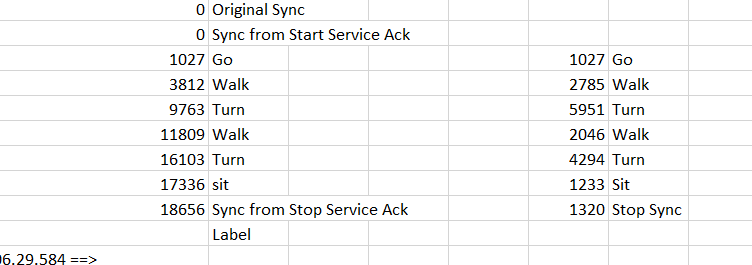-

Dont Expect to see any patterns here since this is just raw resampled X-accleration  compontent, but nice to visualize stages 

In [ ]:
plt.plot(last_df['X Axis'] , label= 'Signal')
plt.plot(last_df['Label']  , 'r--' , label='Activity' )

# green lines for start of phase
for i in range(first_times_df.shape[0]):
  plt.axvline(x = first_times_df.index[i] , color = 'g' , linestyle='dotted')



plt.legend()
plt.show()

In [ ]:
plt.plot(last_df['X Axis'] , label= 'Signal')
plt.plot(last_df['Cat_Label']  , 'r--' , label='Activity' )

# green lines for start of phase 
for i in range(first_times_df.shape[0]):
  plt.axvline(x = first_times_df.index[i] , color = 'g' , linestyle='dotted')



plt.legend()
plt.show()

--------------------------------------


https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/

https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff

https://www.analyticsinsight.net/human-activity-prediction-using-machine-learning/

https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs/blob/master/human_activity_recognition.ipynb

-

-----------------------------------------

# Sliding Window 


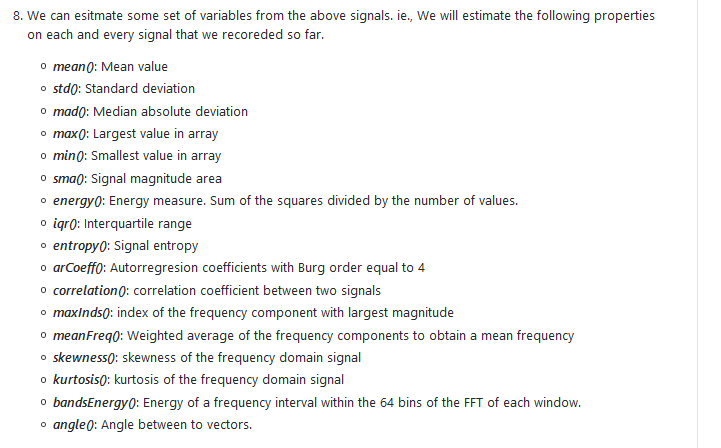

https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs/blob/master/human_activity_recognition.ipynb

In [ ]:
last_df['Label'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [ ]:
# since evenly spaced in 0.01 seconds we can roughly approx how long each phase took 

last_df['Label'].value_counts()

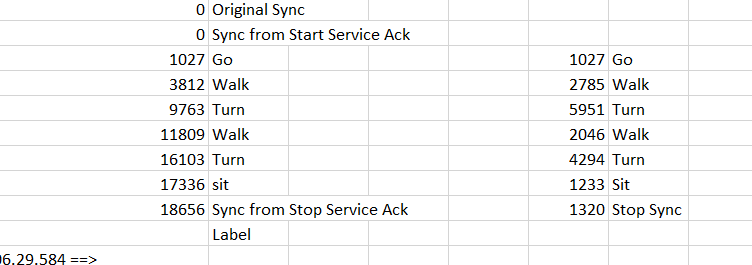-

# HAR Sliding Window 

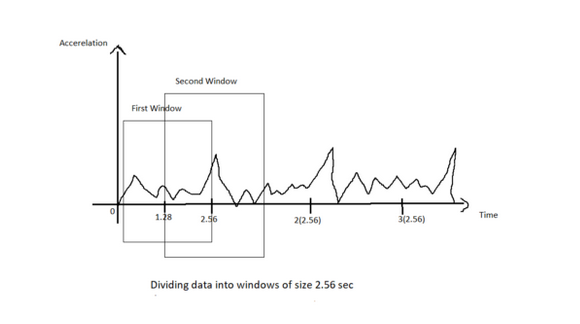

https://www.mdpi.com/1424-8220/19/7/1647/htm


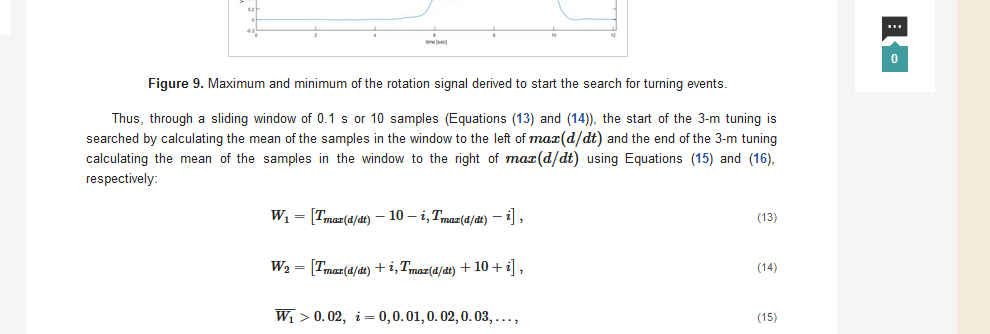

# Time Step 

Every time step of our index is 0.01 seconds.  Therefore To have 2.56 seconds , we would take 256 time steps of the dataframe as a segement. 



In [ ]:
last_df.shape

1849 / 256  = 7.22 segments 

Then for overlap we would have approx 6 segments. 

Some padding may be needed? 

https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-84.pdf

https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs/blob/master/human_activity_recognition.ipynb

https://dsp.stackexchange.com/questions/18649/signal-magnitude-area/18659

In [ ]:
# Signal Magnititude Area 
def sma(x , y , z):
  sum = 0

  for i in range(len(x)):
    sum += np.abs(x[i]) + np.abs(y[i]) + np.abs(z[i])

  return sum /len(x)


# Energy ( sum of squares divided by number of values)
def energy(x , y , z):
  sum_square = 0

  for i in range(len(x)):
    sum_square += (x[i])**2 + (y[i])**2 + (z[i])**2

  return sum_square /len(x)


In [ ]:
from scipy import stats

from scipy.stats import median_absolute_deviation
from sklearn.model_selection import train_test_split

In [ ]:
for i in range(0, 10, 2):

  print(i)

In [ ]:
# Just for X-acceleration as test 

N_TIME_STEPS = 256
N_FEATURES = 3
step = 128 # this will cause 50% overlap 

# hand-crafted features 

# mean 
mean_x = []
mean_y = []
mean_z = []

# std
std_x = []
std_y = []
std_z = []

# median absolute deviation
mad_x = []
mad_y = []
mad_z = []

# max value in segment/ array
max_x = []
max_y = []
max_z = []

# max value in segment/ array
min_x = []
min_y = []
min_z = []

#SMA (signal magnitude area)
sma_acc = [] 

# Energy ( sum of squares divided by number of values)
energy_acc = [] 

# Interquartile range 
iqr_x = []
iqr_y = []
iqr_z = []

# Signal Entropy 
entropy_x = []
entropy_y = []
entropy_z = []

# Correlation between 2 signals
corr_xy = []
corr_xz = []
corr_yz = []


# list to hold segments and labels 
segments = []
segments_2 = []
segments_3 = []

labels = []

for i in range(0, len(last_df) - N_TIME_STEPS, step):

    # replicating the 3 measurements 

    # Acceleration
    xs = last_df['X Axis'].values[i: i + N_TIME_STEPS]
    ys = last_df['Y Axis'].values[i: i + N_TIME_STEPS]
    zs = last_df['Z Axis'].values[i: i + N_TIME_STEPS]

    segments.append([xs, ys, zs])

    # Magnetmeter 
    xs_2 = last_df['Y Axis'].values[i: i + N_TIME_STEPS]
    ys_2 = last_df['X Axis'].values[i: i + N_TIME_STEPS]
    zs_2 = last_df['Z Axis'].values[i: i + N_TIME_STEPS]

    segments_2.append([xs_2, ys_2, zs_2])

    # Gyro 
    xs_3 = last_df['Z Axis'].values[i: i + N_TIME_STEPS]
    ys_3 = last_df['X Axis'].values[i: i + N_TIME_STEPS]
    zs_3 = last_df['Z Axis'].values[i: i + N_TIME_STEPS]

    segments_3.append([xs_3, ys_3, zs_3])

    label = stats.mode(last_df['Label'][i: i + N_TIME_STEPS])[0][0]
    labels.append(label)

    ################# "hand crafted" features #################################

    # mean of segment
    x_mean_segment = np.mean(xs)
    y_mean_segment = np.mean(ys)
    z_mean_segment = np.mean(zs)

    mean_x.append(x_mean_segment)
    mean_y.append(y_mean_segment)
    mean_z.append(z_mean_segment)

    #std of segement 
    x_std_segment = np.std(xs)
    y_std_segment = np.std(ys)
    z_std_segment = np.std(zs)

    std_x.append(x_std_segment)
    std_y.append(y_std_segment)
    std_z.append(z_std_segment)

    # median absolute deviation 
    x_mad_segment = stats.median_absolute_deviation(xs)
    y_mad_segment = stats.median_absolute_deviation(ys)
    z_mad_segment = stats.median_absolute_deviation(zs)

    mad_x.append(x_mad_segment)
    mad_y.append(y_mad_segment)
    mad_z.append(z_mad_segment)

    # max value in segment/array
    x_max_segment = np.max(xs)
    y_max_segment = np.max(ys)
    z_max_segment = np.max(zs)

    max_x.append(x_max_segment)
    max_y.append(y_max_segment)
    max_z.append(z_max_segment)


    # max value in segment/array
    x_min_segment = np.min(xs)
    y_min_segment = np.min(ys)
    z_min_segment = np.min(zs)

    min_x.append(x_min_segment)
    min_y.append(y_min_segment)
    min_z.append(z_min_segment)

    # SMA (signal magnitude area)
    sma_segment = sma(xs , ys, zs)

    sma_acc.append(sma_segment)

    # Energy (sum of squares divided by number of values)
    energy_segment = energy(xs , ys, zs)

    energy_acc.append(energy_segment)

    # IQR 
    x_iqr_segment = stats.iqr(xs)
    y_iqr_segment = stats.iqr(ys)
    z_iqr_segment = stats.iqr(zs)

    iqr_x.append(x_iqr_segment)
    iqr_y.append(y_iqr_segment)
    iqr_z.append(z_iqr_segment)

    # Signal Entropy 
    x_entropy_segment = stats.entropy(xs)
    y_entropy_segment = stats.entropy(ys)
    z_entropy_segment = stats.entropy(zs)

    entropy_x.append(x_entropy_segment)
    entropy_y.append(y_entropy_segment)
    entropy_z.append(z_entropy_segment)

    # Correlation between 2 signals
    xy_corr_segment = np.corrcoef(xs,ys)
    xz_corr_segment = np.corrcoef(xs,zs)
    yz_corr_segment = np.corrcoef(ys,zs)

    # since this is a matrix with 1 on diagonal and off diagonal are equal
    # just access one of the off diagonal elements 
    corr_xy.append(xy_corr_segment[0][1])
    corr_xz.append(xz_corr_segment[0][1])
    corr_yz.append(yz_corr_segment[0][1])

-------------------------------------------

Would padding & using the full  be needed for final part of signal 

https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/

In [ ]:
N_TIME_STEPS = 256
N_FEATURES = 3
step = 128 # this will cause 50% overlap 

for i in range(0, len(last_df) - N_TIME_STEPS, step):

  print(i , i+258)

In [ ]:
N_TIME_STEPS = 10
N_FEATURES = 3
step = 5 # this will cause 50% overlap 

print(len(last_df))

for i in range(0, len(last_df)-step , step):

  print(i , i+step)

-----------------------------------

In [ ]:
print(labels)

# Would a tighter sliding window be more of interest?  

-----------------------------------------------

# Hand Crafted Features 

In [ ]:
mean_x

In [ ]:
std_x

In [ ]:
mad_x

----------------------------------------------
Put handcraft into a dataframe , just some for example

In [ ]:
handcraft_features_segment_df = pd.DataFrame()

In [ ]:
handcraft_features_segment_df['Max Acceleration'] = max_x
handcraft_features_segment_df['Min Acceleration'] = min_x
handcraft_features_segment_df['Label_hand'] = labels

In [ ]:
handcraft_features_segment_df

-----------------------------------------------------------

# Segment Signals 

In [ ]:
last_df.head(5)

In [ ]:
last_df.tail(5)

In [ ]:
print(np.array(segments).shape)
print(np.array(segments_2).shape)
print(np.array(segments_3).shape)

In [ ]:
# X-Axis
(segments[-1][0])

In [ ]:
# Y-Axis
(segments[-1][1])

In [ ]:
# Z- Axis
segments[-1][2]

--------------------------------------------

In [ ]:
# set up an array of size  256 (n_time_steps )  rows and 3 cols [ X , Y , Z ]

array_setup_checker =  [ [ [ None for y in range( 3 ) ] for x in range( 256 ) ] for z in range(13) ]

array_setup_checker_22 =  [ [ None for y in range( 3 ) ] for x in range( 256 ) ]

np.array(array_setup_checker).shape

In [ ]:
# Should be first element of each has value

for window in range(np.array(array_setup_checker).shape[0]):

  for i in range(np.array(array_setup_checker).shape[1]):
    array_setup_checker[window][i][0] = segments[window][0][i]
    array_setup_checker[window][i][1] = segments[window][1][i]
    array_setup_checker[window][i][2] = segments[window][2][i]

In [ ]:
np.array(array_setup_checker).shape

In [ ]:
array_setup_checker

In [ ]:
# join them all together 
segment_all = np.concatenate((segments , segments_2 , segments_3 ))

In [ ]:
segment_all.shape

In [ ]:
segment_all[0][1][0]

########################## Need to look into reshape #########################

In [ ]:
# set up an array of size  50 (n_time_steps )  rows and 9 cols [ X , Y , Z ]


array_setup_checker =  [ [ [ None for y in range( 9 ) ]  for x in range( 256 ) ] for z in range( 13) ]

np.array(array_setup_checker).shape


In [ ]:
for window in range(np.array(array_setup_checker).shape[0]):

  for segment in range(np.array(array_setup_checker).shape[1]):

    # col 1 
    array_setup_checker[window][segment][0] = segment_all[window][segment]

    # col 2
    array_setup_checker[window][segment][1] = segment_all[window]

    # col 3 
    array_setup_checker[window][segment][2] = segment_all[window]



In [ ]:
# 

In [ ]:
np.array(segment_all).shape

In [ ]:
reshaped_segments.shape

In [ ]:
reshaped_segments[0][0][:3]

--------------------------------------------

Now just to check how muliple excel files will be added together 

In [ ]:
# imaginery second persons data (just a copy of original though just for sake of ease )

reshaped_segments_2 = reshaped_segments
labels_2 = labels

In [ ]:
# want a shape of 26 , 256, 9 
# this would be when reading in both excel files and adding together

all_together_reshaped_segments = np.concatenate((reshaped_segments , reshaped_segments_2))

In [ ]:
all_together_reshaped_segments.shape

In [ ]:
# can see the 9 signals - x acc y acc z acc etc... 

reshaped_segments[0][0]

In [ ]:
# this would be when reading in both excel files and adding together for labels
all_together_labels = np.concatenate((labels , labels_2))

In [ ]:
all_together_labels.shape

In [ ]:
labels[0]

In [ ]:

# X_train, X_test, y_train, y_test = train_test_split(
#         reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)



----------------------------------------
Looking into padding series , so will have a constant size but also cover each part of the signal 


In [ ]:
# Padding issue 

N_TIME_STEPS = 256
step = 128

# list to hold segments and labels 
segments_test_pad = []

for i in range(0, len(last_df) , step):

  print(f"-------------------{i} TO {i + N_TIME_STEPS}--------------------")

  xs = last_df['X Axis'].values[i: i + N_TIME_STEPS]
  ys = last_df['Y Axis'].values[i: i + N_TIME_STEPS]
  zs = last_df['Z Axis'].values[i: i + N_TIME_STEPS]

  
  if  (i + step >= len(last_df)) or (i + N_TIME_STEPS >= len(last_df) ):
    print('Hit IF Statement, all signal covered')

    xs = np.zeros(N_TIME_STEPS)
    ys = np.zeros(N_TIME_STEPS)
    zs = np.zeros(N_TIME_STEPS)

    x = last_df['X Axis'].values[i::]
    y = last_df['Y Axis'].values[i::]
    z = last_df['Z Axis'].values[i::]

    xs[:len(x)] = x
    ys[:len(y)] = y
    zs[:len(z)] = z

    print(len(xs))
    segments_test_pad.append([xs, ys, zs])


  else:
    # fine to just append 
    print(len(xs))
    segments_test_pad.append([xs, ys, zs])


In [ ]:
np.array(segments_test_pad).shape

In [ ]:
reshaped_segments_test = np.asarray(segments_test_pad, dtype= np.float32).reshape(-1, N_TIME_STEPS, 3)

print(reshaped_segments_test.shape)

_

_

_

_

_

_

_

_

_

-------------------------------------------------

# Function for find Fc - Dont think its needed but just keeping incase  

# Function to pick fc by min error of fc val - 9.81 ( which is gravity )

In [ ]:

def find_fc( x , y , z,  start = 0.00001 , end= 5 , step = 0.01 , fs = 100 , tol = 0.01 ):

  index = 0 
  vals = []
  diffs = []
  tol = tol
  stds_list = []

  # set best fc as something really high so always will have something better 
  best_fc = np.inf
  best_diff = np.inf
  best_std = np.inf

  # setting sample frequency
  fs = fs 

  # cut off frequency range
  fc = np.arange(start, end , step)

  # this  is defining the accceleration data 
  x = x 
  y = y 
  z = z 

  for val in fc:

    fc = val
    w = fc/(fs/2)
    b,a = signal.butter(3, w, 'low')

    x_filtered = signal.filtfilt(b,a,x)
    y_filtered = signal.filtfilt(b,a,y)
    z_filtered = signal.filtfilt(b,a,z)

    x_squared = x_filtered**2
    y_squared = y_filtered**2
    z_squared = z_filtered**2

    total_squared = x_squared + y_squared  + z_squared 

    # want the mean of this to keep gravity constant throughout the trial 
    value_total_acc = np.sqrt(np.mean(total_squared))

    # calculating std 
    std_total =  np.std(total_squared)

    stds_list.append(std_total)
    vals.append(value_total_acc)

    diff =  value_total_acc - 9.81 

    diffs.append(diff)

    index += 1

    # we want to minimize this as close to zero, so include absolute val
    if ( abs(diff) < abs(best_diff)  and  abs(std_total) <= 1  )  or  (abs(diff) == abs(best_diff) and abs(std_total) < abs(best_std) ) :
      best_diff = diff
      best_std = std_total
      best_fc = val 
      index_val = index
      best_x = x_filtered 
      best_y = y_filtered
      best_z = z_filtered

  # Want some sort of error message, if the value is within tolerance 
  if best_diff > tol:
    print(f"Please widen start and stop range, current best value {value_total_acc} > tolerance {tol}")
    
  else:
    return best_fc, best_diff , best_std  , stds_list,  vals , diffs , index_val , best_x ,best_y , best_z 

In [ ]:
#fc_test = find_fc(raw_acc_1_resampled['X Axis'] , raw_acc_1_resampled['Y Axis'] , raw_acc_1_resampled['Z Axis'] , start = 3 , end= 4 ,step = 0.1 , tol = 0.0000000001 )


In [ ]:
#fc_1 = find_fc(x1_median_20hz, y1_median_20hz, z1_median_20hz, start = 0.01 , end= 0.8 ,step = 0.001 )


------------------------------

https://stackoverflow.com/questions/37996295/how-to-save-numpy-array-into-computer-for-later-use-in-python

https://pythonexamples.org/pandas-write-dataframe-to-excel-sheet/

https://www.nature.com/articles/s41467-020-15086-2#citeas

https://github.com/negargolestani/Activity_Detection

---------------------
State of Art 

1)
https://www.sciencedirect.com/science/article/pii/S0957417418302136


2)
https://www.sciencedirect.com/science/article/pii/S1877050914008643

3)
https://www.sciencedirect.com/science/article/pii/S1877050919310166

4)
https://arxiv.org/pdf/1806.05226.pdf


